In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from numpy.linalg import multi_dot
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#Read Data
data = pd.read_csv('/content/data.csv')
data.drop('Unnamed: 0',axis = 1,inplace = True)
data.head()

,x,y,label
0,-0.975749,2.465522,0.0
1,-0.907734,0.970229,0.0
2,-0.687242,1.831973,0.0
3,-1.482991,1.091349,0.0
4,-1.599863,0.089690,0.0


# QUESTION 1

Examine the data.

*   The number of features, the number of classes and their probabilities P(Ci).
*   Plot the data in a scatter plot using different colors for each class.
*   Partition the data into training (80%) and evaluation set (20%) randomly.
*   Compute the mean vector and covariance matrix for each class from the training set.


## ITEM 1

The number of features, the number of classes and their probabilities $P(C_i)$.

In [ ]:
data.columns

Index(['x', 'y', 'label'], dtype='object')

We have 2 features **x** and **y**.



In [ ]:
data['label'].value_counts()

1.0    400
0.0    200
Name: label, dtype: int64

We have 2 classes **1** and **0**.

$P(C_i)$ = #$C_i /N$ 


*   $P(C_i)$ For class **0**: $P(C_0) =$ # $C_0/N $ 
*   $P(C_i)$ For class **1**: $P(C_1) =$ # $C_1/N $ 


In [ ]:
no_c0 = data['label'].value_counts()[0] # Number of Class 0
no_c1 = data['label'].value_counts()[1] # Number of Class 1
N = data.shape[0] # Number of data samples

In [ ]:
c0_prob = no_c0 / N
c1_prob = no_c1 / N

print("Probability of Class 0: {}".format(c0_prob))
print("Probability of Class 1: {}".format(c1_prob))

Probability of Class 0: 0.3333333333333333
Probability of Class 1: 0.6666666666666666


## ITEM 2

Plot the data in a scatter plot using different colors for each class.

Text(0, 0.5, 'x2')

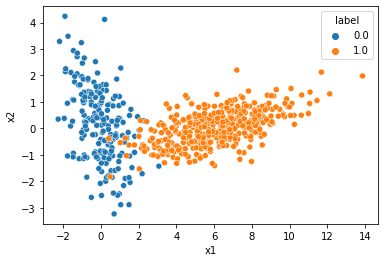

In [ ]:
sns.scatterplot('x', 'y', data=data, hue='label')

plt.xlabel("x1")
plt.ylabel("x2")

## ITEM 3

Partition the data into training (80%) and evaluation set (20%) randomly.

In [ ]:
from sklearn.model_selection import train_test_split

x = data.loc[:,['x','y']]
y = data.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=2020)
x_train.shape, x_test.shape

((480, 2), (120, 2))

## ITEM 4

Compute the mean vector and covariance matrix for each class from the training set.



1.   Mean Vector

>$m_i=  \frac{1}{N_i}\sum_{j=1}^{N_i} x_{i,j}$  where $x_{i,j}$ is sample j from class i, and $N_i$ is the number of training samples from class i


2.   Covariance Matrix S

$S: s_{ij} = \frac{\sum_{t=1}^{N} (x_i^t-m_i)(x_j^t-m_j)}{N}$




In [ ]:
#Compute the mean vectors for each class

train_data = pd.concat([x_train,y_train],axis = 1)
class_feature_means = pd.DataFrame()

for c, rows in train_data.groupby('label'):
    class_feature_means[c] = rows.mean()

class_feature_means.drop(['label'],axis = 0,inplace=True)
class_feature_means

,0.0,1.0
x,-0.020470,6.059459
y,0.145745,0.026007


In [ ]:
m0 = class_feature_means[0].values.reshape(2,1)
m1 = class_feature_means[1].values.reshape(2,1)

In [ ]:
#Covariance Matrix for class 0
rows0 = train_data[train_data['label'] == 0].drop(['label'],axis = 1)

class0_cov_matrix = np.zeros((2,2))
covariance_0 = np.zeros((2,2))

for index, row in rows0.iterrows():
  x = row.values.reshape(2,1)
  covariance_0 += (x - m0).dot((x - m0).T)

class0_cov_matrix += covariance_0/len(rows0)

class0_cov_matrix

array([[ 0.85136583, -0.57286741],
       [-0.57286741,  1.8883089 ]])

In [ ]:
#Covariance Matrix for class 1

rows1 = train_data[train_data['label'] == 1].drop(['label'],axis = 1)

class1_cov_matrix = np.zeros((2,2))
covariance_1 = np.zeros((2,2))

for index, row in rows1.iterrows():
  x = row.values.reshape(2,1)
  covariance_1 += (x - m1).dot((x - m1).T)

class1_cov_matrix += covariance_1/len(rows1)

class1_cov_matrix

array([[4.55393966, 0.80551722],
       [0.80551722, 0.41910882]])

# QUESTION 2

Assume that class-conditional densities are Normal. Design a linear discriminant classifier with a shared covariance matrix using MLE estimators. Obtain the training and evaluation accuracies. Plot a contour plot that shows the decision boundary.

In [ ]:
#Estimations of P(Ci)'s

est_c0_prob = train_data['label'].value_counts()[0] / train_data.shape[0]
est_c1_prob = train_data['label'].value_counts()[1] / train_data.shape[0]

#Shared common sample covariance S

s0 = np.dot(class0_cov_matrix,est_c0_prob)
s1 = np.dot(class1_cov_matrix,est_c1_prob)
S = s0+s1
S

array([[3.30432099, 0.34031241],
       [0.34031241, 0.91496385]])

In [ ]:
#Linear discriminant parameters (wi,wi0)

def gi_linear_parameters(S,mi,est_class_prob):

  cov_inv = linalg.inv(S)
  w_i = np.dot(cov_inv,mi)
  w_i0 = (-.5 * multi_dot([mi.T,cov_inv,mi])) + np.log(est_class_prob)

  return w_i,w_i0

#Linear discriminant function 

def gi_linear_disc(x_vec,S,mi,est_class_prob):

  w_i,w_i0 = gi_linear_parameters(S,mi,est_class_prob)
  gi = w_i.T.dot(np.array([x_vec]).T) + w_i0
  
  return gi

In [ ]:
#Prediction function for linear discriminant

def prediction(X):
  
  y_pred = []

  for index, rows in X.iterrows():

    g0 = gi_linear_disc(rows,S,m0,est_c0_prob)
    g1 = gi_linear_disc(rows,S,m1,est_c1_prob)

    if g0 < g1:
      y_pred.append(1)
    else:
      y_pred.append(0)

  y_pred = pd.Series(y_pred)

  return y_pred

## Accuracy for Linear Discriminant Function

In [ ]:
#Computation of  Accuracy for Linear Discriminant Function

from sklearn.metrics import accuracy_score

y_pred_train = prediction(x_train)

y_pred_test = prediction(x_test)

print("Accuracy score for training data {}".format(accuracy_score(y_train, y_pred_train)))

print("Accuracy score for test data {}".format(accuracy_score(y_test, y_pred_test)))


Accuracy score for training data 0.975
Accuracy score for test data 0.9583333333333334


## Contour Plot for Linear Discriminant Function


In [ ]:
# Decision Boundary Equation Function
def desicion_boundary_linear(X):
  z = []
  for rows in X:
    g0 = gi_linear_disc(rows,S,m0,est_c0_prob)
    g1 = gi_linear_disc(rows,S,m1,est_c1_prob)
    z.append(g0-g1)
  return z

In [ ]:
x1 = np.linspace(data['x'].min()-1, data['x'].max()+1, N)
x2 = np.linspace(data['y'].min()-1, data['y'].max()+1, N)
    
X, Y = np.meshgrid(x1, x2)

zz = np.array([X.ravel(), Y.ravel()]).T

Z = desicion_boundary_linear(zz)

Z = np.reshape(Z,X.shape).T

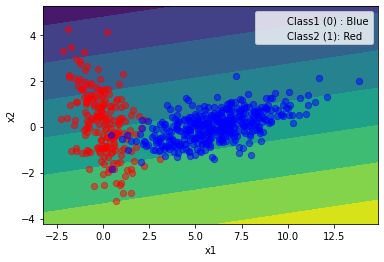

In [ ]:
countour_plt = plt.contourf(X, Y, Z)
fig.colorbar(countour_plt) # Add a colorbar to a plot

plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], marker='o', color='red', s=40, alpha=0.5)
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], marker='o', color='blue', s=40, alpha=0.5)

plt.legend(['Class1 (0) : Blue', 'Class2 (1): Red'], loc='upper right') 
plt.ylabel('x2')
plt.xlabel('x1')



plt.show()

# QUESTION 3

Design a quadratic discriminant classifier using different covariance matrices instead of a linear one. Obtain the training and evaluation accuracies. Plot a contour plot that shows the decision boundary.

Covariance matrices for each class are arbitrary

In [ ]:
#Quadratic discriminant parameters (wi,wi0)

def gi_quadratic_parameters(s,mi,est_class_prob):

  cov_inv = linalg.inv(s)
  cov_det = linalg.det(s)
  W_i = (-.5*cov_inv)
  w_i = np.dot(cov_inv,mi)
  w_i0 = (-.5 * multi_dot([mi.T,cov_inv,mi])) - (.5* np.log(cov_det)) + np.log(est_class_prob)

  return W_i, w_i, w_i0

#Quadratic discriminant function 

def gi_quadratic_disc(x_vec,s,mi,est_class_prob):

  W_i, w_i,w_i0 = gi_quadratic_parameters(s,mi,est_class_prob)
  gi = multi_dot([np.array([x_vec]),W_i,np.array([x_vec]).T]) + w_i.T.dot(np.array([x_vec]).T) + w_i0
  
  return gi

In [ ]:
#Prediction function for quadratic discriminant

def prediction(X):
  
  y_pred = []

  for index, rows in X.iterrows():

    g0 = gi_quadratic_disc(rows,class0_cov_matrix,m0,est_c0_prob)
    g1 = gi_quadratic_disc(rows,class1_cov_matrix,m1,est_c1_prob)

    if g0 < g1:
      y_pred.append(1)
    else:
      y_pred.append(0)

  y_pred = pd.Series(y_pred)

  return y_pred

## Accuracy for Quadratic Discriminant Function

In [ ]:
#Computation of  Accuracy for Quadratic Discriminant Function

from sklearn.metrics import accuracy_score

y_pred_train = prediction(x_train)

y_pred_test = prediction(x_test)

print("Accuracy score for training data {}".format(accuracy_score(y_train, y_pred_train)))

print("Accuracy score for test data {}".format(accuracy_score(y_test, y_pred_test)))


Accuracy score for training data 0.9875
Accuracy score for test data 0.9583333333333334


## Contour Plot for Quadratic Discriminant Funtion


In [ ]:
# Decision Boundary Equation Function
def desicion_boundary_quadratic(X):
  z = []
  for rows in X:
    g0 = gi_quadratic_disc(rows,class0_cov_matrix,m0,est_c0_prob)
    g1 = gi_quadratic_disc(rows,class1_cov_matrix,m1,est_c1_prob)
    z.append(g0-g1)
  return z

In [ ]:
x1 = np.linspace(data['x'].min()-1, data['x'].max()+1, N)
x2 = np.linspace(data['y'].min()-1, data['y'].max()+1, N)
    
X, Y = np.meshgrid(x1, x2)

zz = np.array([X.ravel(), Y.ravel()]).T

Z = desicion_boundary_quadratic(zz)

Z = np.reshape(Z,X.shape).T


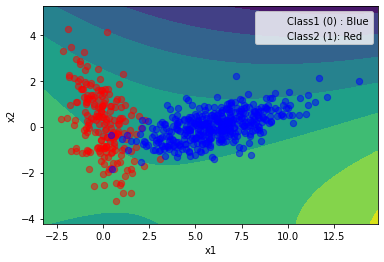

In [ ]:
countour_plt = plt.contourf(X, Y, Z)
fig.colorbar(countour_plt) # Add a colorbar to a plot

plt.scatter(data[data['label'] == 0]['x'], data[data['label'] == 0]['y'], marker='o', color='red', s=40, alpha=0.5)
plt.scatter(data[data['label'] == 1]['x'], data[data['label'] == 1]['y'], marker='o', color='blue', s=40, alpha=0.5)

plt.legend(['Class1 (0) : Blue', 'Class2 (1): Red'], loc='upper right') 
plt.ylabel('x2')
plt.xlabel('x1')

plt.show()